In [24]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import piecewise_regression
import matplotlib.lines as mlines
from typing import List, Dict
from os import path
from config import ROOT_PATH, DATA_PATH

# 1) Read VPA data

In [25]:
# Read catch, and mortality rates (1)
# ---> read weight at age
data_path =path.join(DATA_PATH, 'project', 'vpa', 'weight_age.csv')
w = pd.read_csv(data_path)

# ---> read weight at age SD25
data_path =path.join(DATA_PATH, 'project', 'vpa', 'weight_age_25.csv')
w25 = pd.read_csv(data_path)

# ---> read weight at age
data_path =path.join(DATA_PATH, 'project', 'vpa', 'maturity_rate.csv')
mat = pd.read_csv(data_path)

# ---> read fixed natural mortality matrix
data_path =path.join(DATA_PATH, 'project', 'vpa', 'm_mortality_rate.csv')
m = pd.read_csv(data_path)

# ---> read variable natural mortality matrix
data_path =path.join(DATA_PATH, 'project', 'vpa', 'vm_mortality_rate.csv')
vm = pd.read_csv(data_path)

# ---> read fishing mortality matrix
data_path =path.join(DATA_PATH, 'project', 'vpa', 'f_mortality_rate.csv')
f = pd.read_csv(data_path)

# --> read catch matrix
data_path =path.join(DATA_PATH, 'project', 'vpa', 'catch_rate.csv')
c = pd.read_csv(data_path)

# --> abundance matrix
n = f.copy()
n[n.columns[1:]] = 0

# --> Year pandas series
year_series = c.year


# 2) Supporting Code for Abundance and Fishing Mortality Calculation

In [26]:
class Abundance:
    
    def __init__ (self, c: pd.DataFrame, m: pd.DataFrame, f: pd.DataFrame):
        self.c = c
        self.m = m
        self.f = f
    
    def calculate_abundance_last_cols_rows (self) -> pd.DataFrame:
        n = self.f.copy()
        n[n.columns[1:]] = 0
        
        # Calculate abundance for last column (age 8 for all years)
        ct = self.c.iloc[:, -1]
        zt = self.f.iloc[:, -1] + self.m.iloc[:, -1]
        ft = self.f.iloc[:, -1]
        exp_z = 1 - np.exp(-zt)
        #----> update last column
        n.iloc[:, -1] = round((ct * zt) / (ft * exp_z), 2)

        # Calculate abundance for last row (all ages for the last year)
        ct = self.c.iloc[-1, 1:].reset_index(drop=True)
        zt = (self.f.iloc[-1, 1:] + self.m.iloc[-1, 1:]).reset_index(drop=True)
        ft = self.f.iloc[-1, 1:].reset_index(drop=True)
        exp_z = 1 - np.exp(-zt)
        #----> update last rowex
        n.iloc[-1, 1:] = round((ct * zt) / (ft * exp_z), 2)
        return n
    
    def calculate_abundance_rest_cols_rows (self, n: pd.DataFrame) -> pd.DataFrame:
        for col in range(len(n.columns)-1, 1, -1): # Calculation from age 7 to age 1
            nt1 = n.iloc[1:, col].reset_index(drop=True) # Nt+1,a+1
            e_m = np.exp(self.m.iloc[:-1, col-1])
            em_2 = np.exp(self.m.iloc[:-1, col-1] / 2)
            ct = self.c.iloc[:-1, col-1]
            n.iloc[:-1, col-1] = round((nt1 * e_m) + (ct * em_2), 2)
        return n
    
    def calculate (self) -> pd.DataFrame:
        n = self.calculate_abundance_last_cols_rows()
        n = self.calculate_abundance_rest_cols_rows(n)
        return (n)
    

In [27]:
class FishingMortality:
    
    def __init__(self, n: pd.DataFrame, m: pd.DataFrame, f: pd.DataFrame):
        self.n = n
        self.m = m
        self.f = f.copy()
    
    def calculate_all_but_last_row(self) -> pd.DataFrame:
        for col in range(len(self.n.columns)-1, 1, -1): # from age 8 to age 2 but calucations are from age 7 to 1
            nta1 = self.n.iloc[1:, col].reset_index(drop=True) # Nt+1,a+1
            nta = self.n.iloc[:-1, col-1]
            log_n = np.log(nta / nta1)
            mt = self.m.iloc[:-1, col-1]  # mt = M
            self.f.iloc[:-1, col-1] = round(log_n - mt, 2)
        return self.f
        
    def calculate_average_last_row(self, from_col: int, to_col: int):
        f_average = ((self.f.iloc[:-1, from_col:to_col]).mean(axis=1)).values
        self.f.iloc[:-1, -1] = f_average
        return self.f
    
    def calculate(self, from_col: int, to_col: int):
        self.calculate_all_but_last_row()
        self.calculate_average_last_row(from_col, to_col)
        return self.f
    

In [45]:

def calculate_N_and_F (iteration: int, c: pd.DataFrame, m: pd.DataFrame, f: pd.DataFrame):
    for _ in range(iteration):
        abundance = Abundance(c, m, f)
        n = abundance.calculate()
        fishing_mortality = FishingMortality(n, m, f)
        from_col, to_col = 3, 8
        f = fishing_mortality.calculate(from_col, to_col)
    return (n, f)

# 3) VPA with scalar natural moratlity M

## 3.1) Calculate abundance matrix 

Calculate the abundance matrix by using the initial fishing mortality matrix. 

### 3.1.2) Calculate only the last column and row of N matrix of abundance matrix

To calculate the last row (fish of all ages for the last year) and colums (fish of age 8 for all years), use the catch equation: $ \large N_{t} = \frac{C_{t} * Z_{t}}{F_{t} * \ e^{(1 - Z_{t})}} $

### 3.1.2) Calculate rest of abundance matrix using Pope's equation

The Pope's equation $ \large N_{t, a} =  N_{t+1, a+1}e^{M} + C_{t}e^{\frac{M}{2}} $ is used to calculate the rest of the rows



## 3.2) Recalculate fishing mortality submatrix

### 3.2.1) Recalculate the submatrix that excludes the last column and last row

We exclude the last column from the calculation which corresponds to age 8 and use the formula $ \large log_n (\frac{N_{t,a}}{N_{t+1,a+1}}) - M$

### 3.2.2) Recalculate the last column of the fishing mortality matrix

The last column and for all cells, except the last one the calculation is performed by calculating the average fishing mortality of all ages between 3 and 7. This is because the fishing mortality at early stage of fish life is neglible.

## 3.3) Recalculate the abundance matrix with the new fishing mortality matrix


In [49]:
n, new_f = calculate_N_and_F (6, c, m, f)

## 3.4) Calculate SSB, Recruitment and average fishing mortality

To compute the fishing mortality we only take into account ages betgween 3 and 5

In [50]:
ssb = f.copy()
ssb[ssb.columns[1:]] = 0
ssb.iloc[:, 1:] = w.iloc[:, 1:] * mat.iloc[:, 1:] * n.iloc[:, 1:]
fm_rs_ssb = pd.DataFrame(data={'year': year_series, 
                               'ssb': ssb.iloc[:, 1:].sum(axis=1), 
                               'rs': n.iloc[:, 1],
                               'fm': new_f.iloc[:, 3:6].mean(axis=1).values}) # note that to compute the fishing mortality we only take into account ages from 3 to 6

In [51]:
fm_rs_ssb

,year,ssb,rs,fm
0,1984,594.485985,24603.30,0.086667
1,1985,650.391597,20177.59,0.120000
2,1986,663.022127,17347.31,0.150000
3,1987,656.089270,21385.33,0.223333
4,1988,598.356686,14479.46,0.156667
5,1989,675.272937,34474.32,0.163333
6,1990,818.897660,40039.49,0.093333
7,1991,974.667916,50921.41,0.143333
8,1992,1237.135333,80986.08,0.163333
9,1993,1536.946147,87924.88,0.153333


## 3.5) Draw resulting graphs (Average fishing mortality, SSB, Recruitment and yearly class-year fishing mortality)

Text(0.5, 0, 'Years')

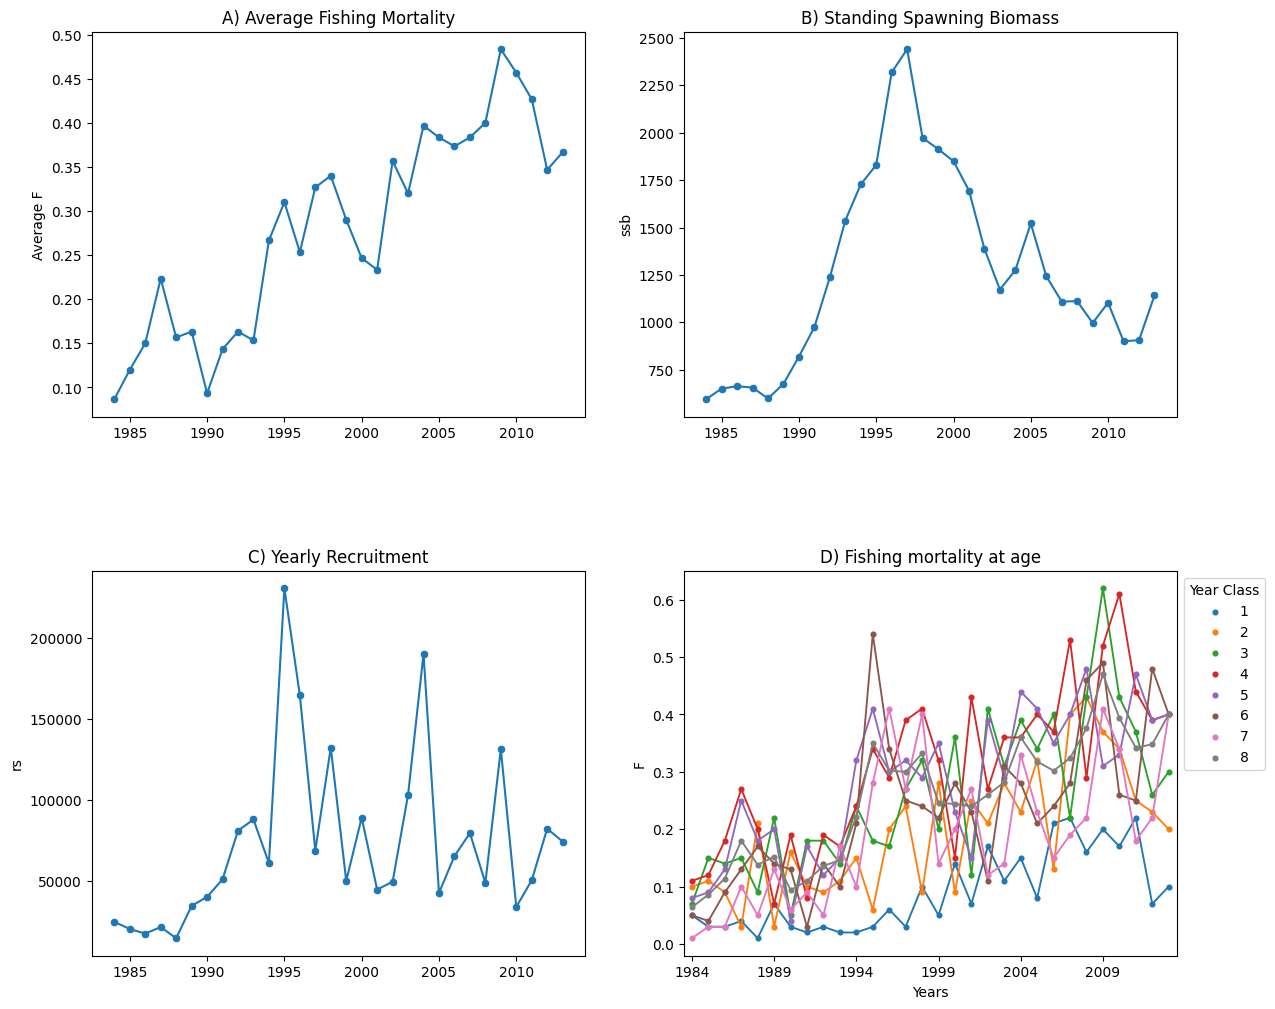

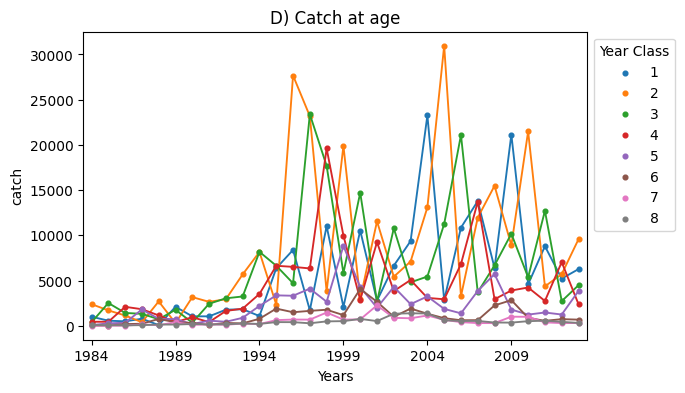

In [52]:
_, ax =plt.subplots(nrows=2, ncols=2, figsize=(14,12))
# Plot fishing mortality
sns.scatterplot(data=fm_rs_ssb, 
                x = "year", 
                y="fm", 
                ax=ax[0][0]).set(title = "A) Average Fishing Mortality")
sns.lineplot(data=fm_rs_ssb, x="year", y="fm", ax=ax[0][0])

# Plot Standing Spawning Biomass
sns.scatterplot(data=fm_rs_ssb, 
                x = "year", 
                y="ssb", 
                ax=ax[0][1]).set(title = "B) Standing Spawning Biomass")
sns.lineplot(data=fm_rs_ssb, x="year", y="ssb", ax=ax[0][1])

# Plot Yearly recruitment
sns.scatterplot(data=fm_rs_ssb, 
                x = "year", 
                y="rs", 
                ax=ax[1][0]).set(title = "C) Yearly Recruitment")
sns.lineplot(data=fm_rs_ssb, x="year", y="rs", ax=ax[1][0])

# Plot absolute fishing mortality at eage
f_long = new_f.melt('year', var_name='year_class', value_name='mortality')
sns.pointplot(x="year", y="mortality", hue='year_class', data=f_long, scale=0.5, ax=ax[1][1]).set(title = "D) Fishing mortality at age")
sns.move_legend(ax[1][1], "upper left", bbox_to_anchor=(1, 1), title='Year Class')
ax[1][1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

# Adjust features of all graphs
plt.subplots_adjust(wspace = 0.2, hspace=0.4)
ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[1][0].set_xlabel('')
ax[0][0].set_ylabel('Average F')
ax[1][1].set_ylabel('F')
ax[1][1].set_xlabel('Years')

# Plot catch at age
_, ax =plt.subplots(figsize=(6.5,4))
c_long = c.melt('year', var_name='year_class', value_name='catch')
sns.pointplot(x="year", y="catch", hue='year_class', data=c_long, scale=0.5, ax=ax).set(title = "D) Catch at age")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='Year Class')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax.set_xlabel('Years')

# 4) VPA with variable natural mortality M

## 4.1 Calculate the abundance and fihsing mortality matrices

In [53]:
n, new_f = calculate_N_and_F (6, c, vm, f)

In [56]:
n

,year,1,2,3,4,5,6,7,8
0,1984,83637.99,92051.44,21530.48,16004.77,3952.46,2936.97,3592.55,4607.25
1,1985,54330.82,43811.47,47279.46,11183.80,8366.71,2133.63,1615.97,2004.73
2,1986,41741.12,31229.12,24231.02,25894.80,6304.34,4814.17,1270.75,965.34
3,1987,38012.42,25696.96,18615.44,14017.88,14679.24,3748.33,2919.53,805.57
4,1988,26328.96,24099.13,16398.33,11044.88,7724.60,8271.44,2326.73,1835.03
5,1989,49656.18,17064.32,13502.27,10078.49,6325.64,4505.67,4870.21,1491.18
6,1990,50977.86,31890.46,11314.89,7683.74,6558.20,3714.74,2788.09,3033.24
7,1991,64198.81,35759.75,20238.14,7841.17,4768.30,4602.03,2428.18,1929.13
8,1992,102851.27,47612.81,24723.71,13175.29,5572.40,3109.14,3420.48,1713.83
9,1993,118460.50,76957.59,33778.79,16217.48,8622.23,3906.73,2124.22,2531.12


## 4.2 Calculate SSB, Recruitment and average fishing mortality


In [54]:
ssb_vm = f.copy()
ssb_vm[ssb.columns[1:]] = 0
ssb_vm.iloc[:, 1:] = w.iloc[:, 1:] * mat.iloc[:, 1:] * n_vm.iloc[:, 1:]
fm_rs_ssb_vm = pd.DataFrame(data={'year': year_series, 
                               'ssb': ssb_vm.iloc[:, 1:].sum(axis=1), 
                               'rs': n_vm.iloc[:, 1],
                               'fm': new_f_vm.iloc[:, 3:6].mean(axis=1).values}) # note that to compute the fishing mortality we only take into account ages from 3 to 6

In [55]:
fm_rs_ssb_vm

,year,ssb,rs,fm
0,1984,1897.664324,83637.99,0.033333
1,1985,1531.147113,54330.82,0.053333
2,1986,1291.123267,41741.12,0.086667
3,1987,1133.788283,38012.42,0.143333
4,1988,926.593838,26328.96,0.110000
5,1989,949.806057,49656.18,0.123333
6,1990,1042.074866,50977.86,0.076667
7,1991,1173.857632,64198.81,0.120000
8,1992,1497.566870,102851.27,0.133333
9,1993,1900.169513,118460.50,0.133333


## 4.3 Draw resulting graphs (Average fishing mortality, SSB, Recruitment and yearly class-year fishing mortality)

Text(0.5, 0, 'Years')

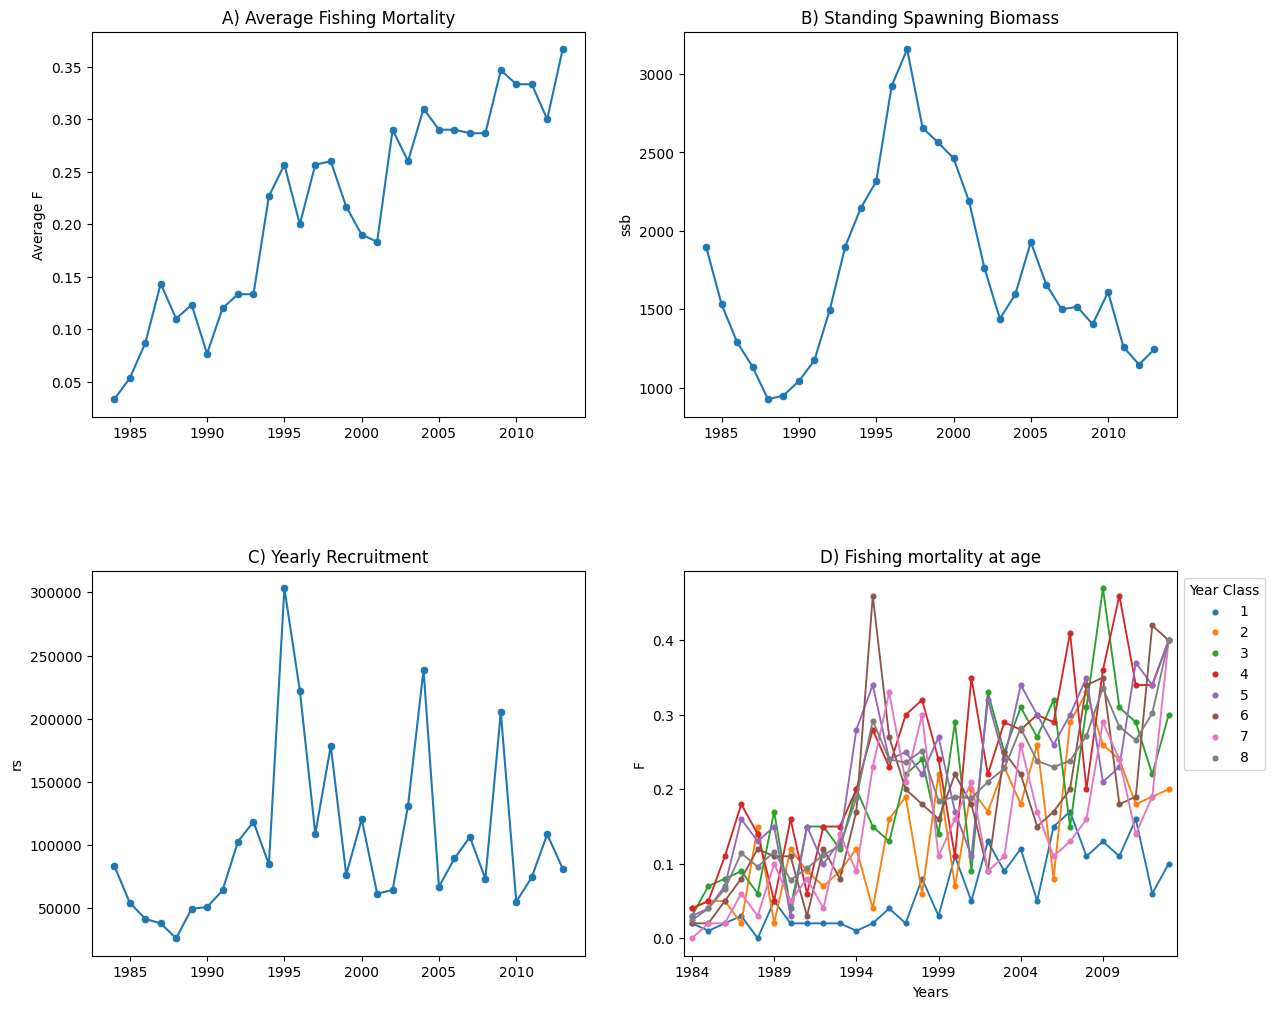

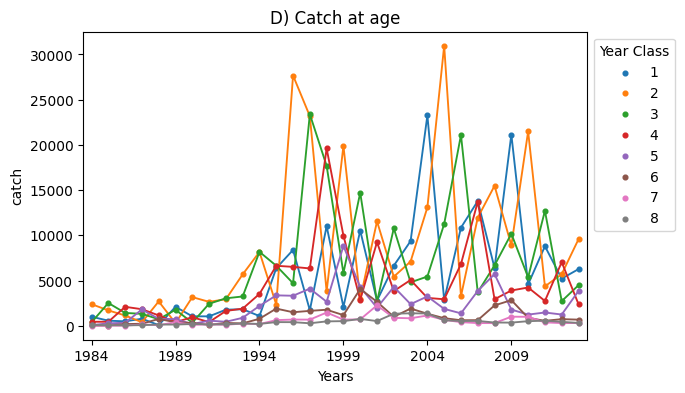

In [57]:
_, ax =plt.subplots(nrows=2, ncols=2, figsize=(14,12))
# Plot fishing mortality
sns.scatterplot(data=fm_rs_ssb_vm, 
                x = "year", 
                y="fm", 
                ax=ax[0][0]).set(title = "A) Average Fishing Mortality")
sns.lineplot(data=fm_rs_ssb_vm, x="year", y="fm", ax=ax[0][0])

# Plot Standing Spawning Biomass
sns.scatterplot(data=fm_rs_ssb_vm, 
                x = "year", 
                y="ssb", 
                ax=ax[0][1]).set(title = "B) Standing Spawning Biomass")
sns.lineplot(data=fm_rs_ssb_vm, x="year", y="ssb", ax=ax[0][1])

# Plot Yearly recruitment
sns.scatterplot(data=fm_rs_ssb_vm, 
                x = "year", 
                y="rs", 
                ax=ax[1][0]).set(title = "C) Yearly Recruitment")
sns.lineplot(data=fm_rs_ssb_vm, x="year", y="rs", ax=ax[1][0])

# Plot absolute fishing mortality at eage
f_long_vm = new_f_vm.melt('year', var_name='year_class', value_name='mortality')
sns.pointplot(x="year", y="mortality", hue='year_class', data=f_long_vm, scale=0.5, ax=ax[1][1]).set(title = "D) Fishing mortality at age")
sns.move_legend(ax[1][1], "upper left", bbox_to_anchor=(1, 1), title='Year Class')
ax[1][1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

# Adjust features of all graphs
plt.subplots_adjust(wspace = 0.2, hspace=0.4)
ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[1][0].set_xlabel('')
ax[0][0].set_ylabel('Average F')
ax[1][1].set_ylabel('F')
ax[1][1].set_xlabel('Years')

# Plot catch at age
_, ax =plt.subplots(figsize=(6.5,4))
c_long = c.melt('year', var_name='year_class', value_name='catch')
sns.pointplot(x="year", y="catch", hue='year_class', data=c_long, scale=0.5, ax=ax).set(title = "D) Catch at age")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='Year Class')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax.set_xlabel('Years')

# 5) Comparative graphs for Fixed and Variable Mortality

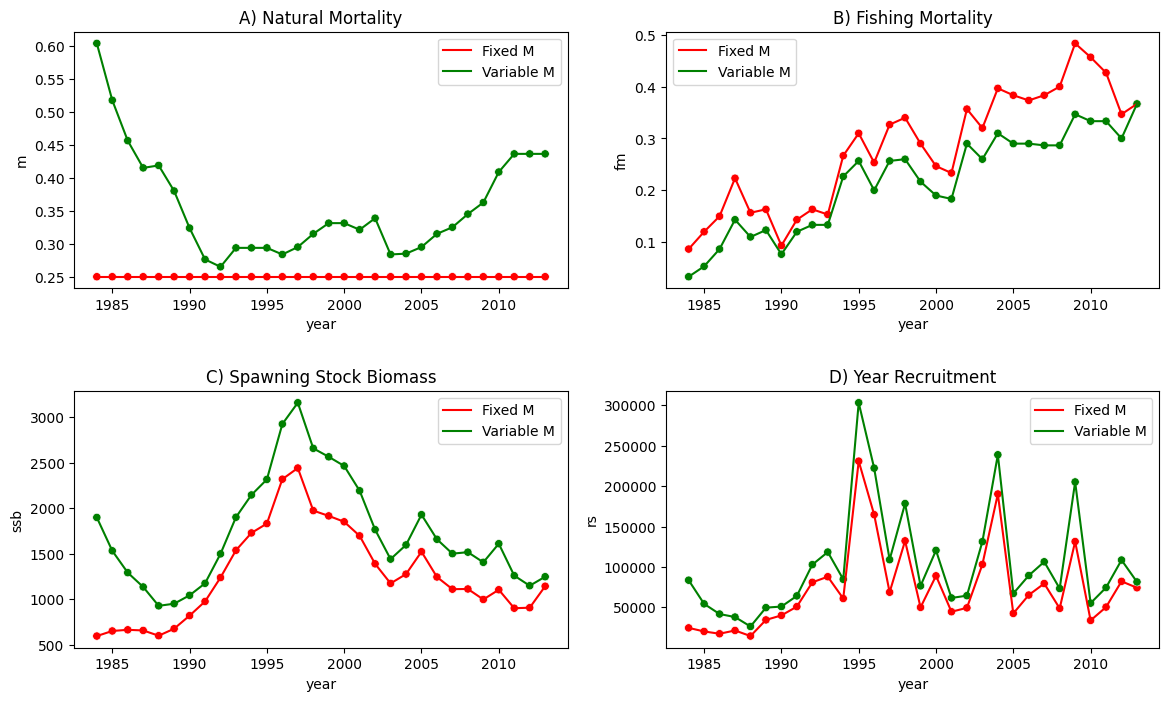

In [58]:
_, ax =plt.subplots(nrows=2, ncols=2, figsize=(14,8))

# 1) Natural mortality comparison when M fixed vs variable
mf_vs_mv = pd.DataFrame(data={'year': year_series, 'm': m.iloc[:, 1:].mean(axis=1), 'm_type': 'Fixed M'})
mvar = pd.DataFrame(data={'year': year_series, 'm': vm.iloc[:, 1:].mean(axis=1), 'm_type': 'Variable M'})
mf_vs_mv = pd.concat([mf_vs_mv, mvar], axis=0, keys=['m', 'm']).reset_index()

sns.scatterplot(data=mf_vs_mv, 
                x = "year", 
                y="m",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[0][0]).set(title = "A) Natural Mortality")
sns.lineplot(data=mf_vs_mv, x='year', y='m', hue='m_type', palette=['r', 'g'], ax = ax[0][0])
ax[0][0].legend(title= "M (variable vs fixed)")

# 2) Fishing mortality comparison when M fixed vs variable
ff_vs_fv = pd.DataFrame(data={'year': year_series, 'fm': fm_rs_ssb.fm, 'm_type': 'Fixed M'})
fv = pd.DataFrame(data={'year': year_series, 'fm': fm_rs_ssb_vm.fm, 'm_type': 'Variable M'})
ff_vs_fv = pd.concat([ff_vs_fv, fv], axis=0, keys=['fm', 'fm']).reset_index()

sns.scatterplot(data=ff_vs_fv, 
                x = "year", 
                y="fm",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[0][1]).set(title = "B) Fishing Mortality")
sns.lineplot(data=ff_vs_fv, x='year', y='fm', hue='m_type', palette=['r', 'g'], ax = ax[0][1])
ax[0][1].legend(title= "F (variable vs fixed)")


# 3) SSB comparison when M fixed vs variable
ssbf_vs_ssbv = pd.DataFrame(data={'year': year_series, 'ssb': fm_rs_ssb.ssb, 'm_type': 'Fixed M'})
ssbv = pd.DataFrame(data={'year': year_series, 'ssb': fm_rs_ssb_vm.ssb, 'm_type': 'Variable M'})
ssbf_vs_ssbv = pd.concat([ssbf_vs_ssbv, ssbv], axis=0, keys=['ssb', 'ssb']).reset_index()

sns.scatterplot(data=ssbf_vs_ssbv,
                x = "year",
                y="ssb",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[1][0]).set(title = "C) Spawning Stock Biomass")
sns.lineplot(data=ssbf_vs_ssbv, x='year', y='ssb', hue='m_type', palette=['r', 'g'], ax = ax[1][0])
ax[1][0].legend(title= "SSB (variable vs fixed)")

# 4) Year Recruitment comparison when M fixed vs variable
rsf_vs_rsbv = pd.DataFrame(data={'year': year_series, 'rs': fm_rs_ssb.rs, 'm_type': 'Fixed M'})
rsv = pd.DataFrame(data={'year': year_series, 'rs': fm_rs_ssb_vm.rs, 'm_type': 'Variable M'})
rsf_vs_rsbv = pd.concat([rsf_vs_rsbv, rsv], axis=0, keys=['rs', 'rs']).reset_index()

sns.scatterplot(data=rsf_vs_rsbv,
                x = "year",
                y="rs",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[1][1]).set(title = "D) Year Recruitment")
sns.lineplot(data=rsf_vs_rsbv, x='year', y='rs', hue='m_type', palette=['r', 'g'], ax = ax[1][1])
ax[1][1].legend(title= "SSB (variable vs fixed)")
ax[1][1].legend(title= "Recruitment (variable vs fixed)")

# Remove dots legend
for i in range(2):
    for j in range(2):
        handles, labels = ax[i][j].get_legend_handles_labels()
        ax[i][j].legend(handles[2:], labels)

plt.subplots_adjust(wspace = 0.2, hspace=0.4)



# 6) VPA with WAA SD25

## 6.1 Compare the two matrices of weights and SSBs

In [59]:
w_av = pd.DataFrame(data={'year':year_series , 'av_weight':w.iloc[:, 1:].mean(axis=1), 'w_type': 'Global WAA'})
w_25_av = pd.DataFrame(data={'year':year_series , 'av_weight':w25.iloc[:, 1:].mean(axis=1), 'w_type': 'WAA SD25'})
ws = pd.DataFrame(data={'w_av': w_av.iloc[:, 1:].av_weight, 'w_25_av': w_25_av.iloc[:, 1:].av_weight})
ws.describe()

,w_av,w_25_av
count,30.000000,30.000000
mean,0.011701,0.012765
std,0.002244,0.001722
min,0.009012,0.009315
25%,0.010006,0.011534
50%,0.010644,0.012696
75%,0.013906,0.014211
max,0.015700,0.015700


In [60]:
# Build the weight matrices to be compared
w_vs_w25 = pd.concat([w_av, w_25_av], axis=0, keys=['av_weight', 'av_weight']).reset_index()

# Build the ssb matrices to be compared.

ssb_global = pd.DataFrame(data={'year': year_series, 'ssb': fm_rs_ssb.ssb, 'ssb_type': 'Global WAA'})

ssb_25 = f.copy()
ssb_25[ssb_25.columns[1:]] = 0
ssb_25.iloc[:, 1:] = w25.iloc[:, 1:] * mat.iloc[:, 1:] * n.iloc[:, 1:]
ssb_25 = pd.DataFrame(data={'year': year_series, 'ssb': ssb_25.iloc[:, 1:].sum(axis=1), 'ssb_type': 'WAA SD25'})
ssb_vs_ssb25 = pd.concat([ssb_global, ssb_25], axis=0, keys=['ssb', 'ssb']).reset_index()
ssb_vs_ssb25 

,level_0,level_1,year,ssb,ssb_type
0,ssb,0,1984,594.485985,Global WAA
1,ssb,1,1985,650.391597,Global WAA
2,ssb,2,1986,663.022127,Global WAA
3,ssb,3,1987,656.089270,Global WAA
4,ssb,4,1988,598.356686,Global WAA
5,ssb,5,1989,675.272937,Global WAA
6,ssb,6,1990,818.897660,Global WAA
7,ssb,7,1991,974.667916,Global WAA
8,ssb,8,1992,1237.135333,Global WAA
9,ssb,9,1993,1536.946147,Global WAA


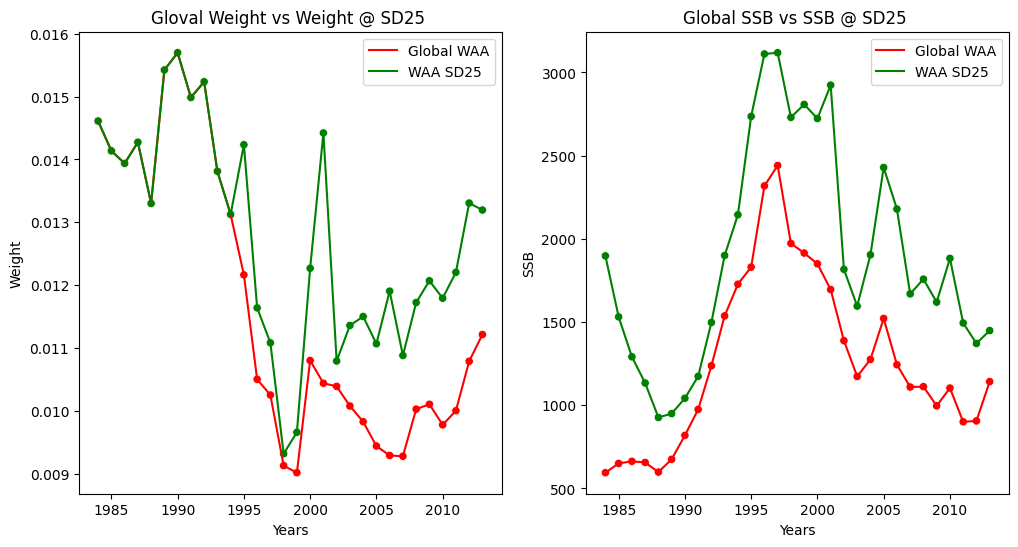

In [61]:
_, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# plot the global weight vs weight 25
s_plot =sns.scatterplot(data=w_vs_w25, 
                x = "year", 
                y="av_weight",
                hue='w_type',
                palette=['r', 'g'], 
                ax=ax[0]).set(title = "Gloval Weight vs Weight @ SD25 ")
l_plot = sns.lineplot(data=w_vs_w25, x='year', y='av_weight', hue='w_type', palette=['r', 'g'], ax=ax[0])
ax[0].set_xlabel('Years')
ax[0].set_ylabel('Weight')

# plot the global ssb vs ssb 25
s_plot =sns.scatterplot(data=ssb_vs_ssb25, 
                x = "year", 
                y="ssb",
                hue='ssb_type',
                palette=['r', 'g'], 
                ax=ax[1]).set(title = "Global SSB vs SSB @ SD25 ")
l_plot = sns.lineplot(data=ssb_vs_ssb25, x='year', y='ssb', hue='ssb_type', palette=['r', 'g'], ax=ax[1])
ax[1].set_xlabel('Years')
ax[1].set_ylabel('SSB')

# Remove dots legend
for i in range(2):
    handles, labels = ax[1].get_legend_handles_labels()
    ax[i].legend(handles[2:], labels)
    

# 6) S-R relationships

* S-R with fixed mortality rate
* S-R with variable mortality rate
* S-R with WAA SD25

## 6.1) Describe the different SSB (fixed M, variable M and different WAA)

In [62]:
# Describe different ssbs
ssb_m = fm_rs_ssb.ssb
ssb_vm = fm_rs_ssb_vm.ssb
ssb_wa_25 = ssb_25.ssb
ssbs = pd.DataFrame(data={'ssbm': ssb_m, 'ssbvm': ssb_vm, 'ssb_waa_25': ssb_wa_25})
ssbs.describe()


,ssbm,ssbvm,ssb_waa_25
count,30.000000,30.000000,30.000000
mean,1267.513920,1727.605112,1893.568443
std,515.227629,592.539813,658.482589
min,594.485985,926.593838,926.593838
25%,901.815292,1266.548518,1460.135029
50%,1157.530032,1563.435572,1787.268958
75%,1655.724580,2090.649046,2366.431618
max,2440.751801,3158.113373,3118.500243


## 6.2) Describe the different Recruitments (fixed M and variable M)


In [63]:
# Describe different recruitments 
rs_m = fm_rs_ssb.rs
rs_vm = fm_rs_ssb_vm.rs
rss = pd.DataFrame(data={'rsm': rs_m, 'rsvm': rs_vm,})
rss.describe()

,rsm,rsvm
count,30.000000,30.000000
mean,72816.412667,102755.373333
std,52095.041062,65434.077698
min,14479.460000,26328.960000
25%,40650.117500,62284.450000
50%,55932.365000,82550.570000
75%,86494.380000,116096.367500
max,230957.680000,303269.150000


## 6.3)S-R relationships with fixed M

In [64]:
s_r_fm = pd.DataFrame(data={'ssb': ssb_m, 'rs': rs_m, 's_r_type': 'Fixed M'})
s_r_vm = pd.DataFrame(data={'ssb': ssb_vm, 'rs': rs_vm, 's_r_type': 'Variable M'})
s_r_fm_waa_25 = pd.DataFrame(data={'ssb': ssb_wa_25, 'rs': rs_m, 's_r_type': 'Fixed M/WAA SD25'})
s_r = pd.concat([s_r_fm, s_r_vm, s_r_fm_waa_25], axis=0, keys=['rs', 'rs', 'rs']).reset_index()

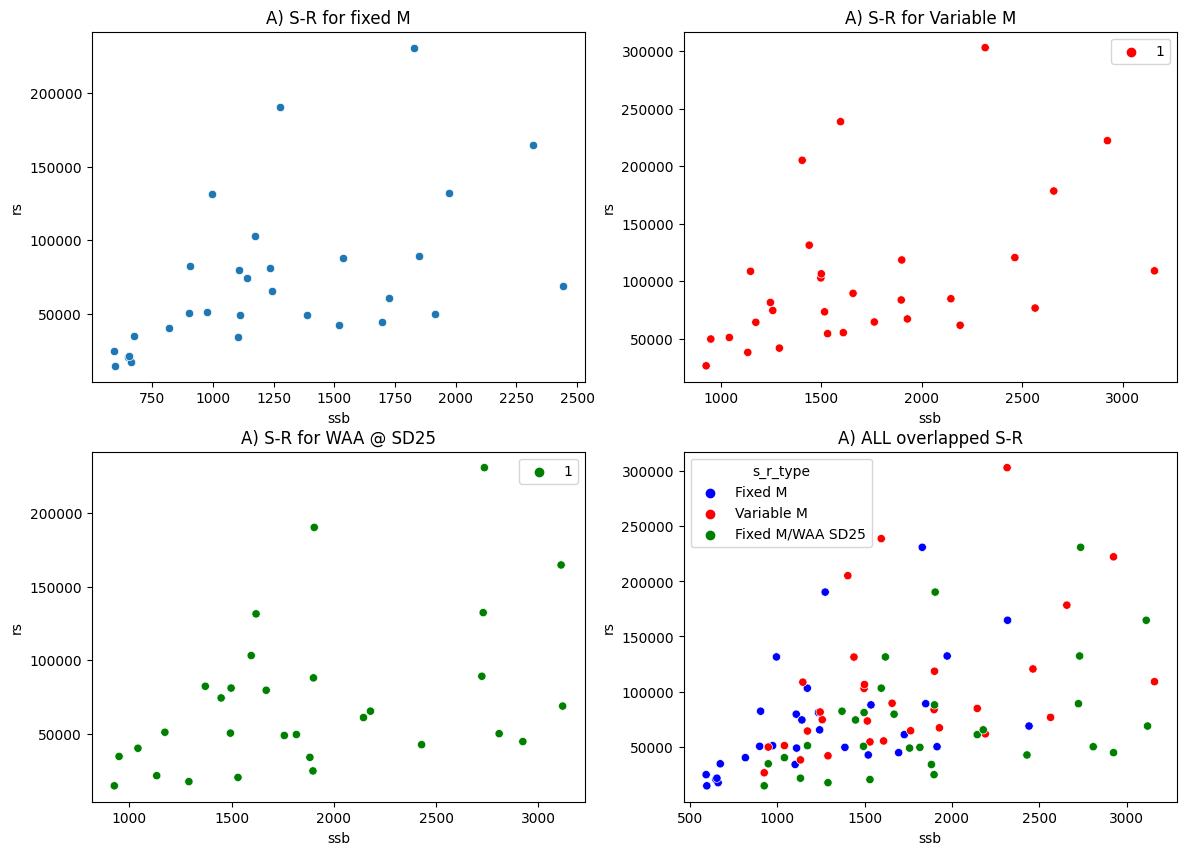

In [65]:
_, ax =plt.subplots(nrows=2, ncols=2, figsize=(14,10))
s_r_fm_plt =sns.scatterplot(data=s_r_fm, 
                x = "ssb", 
                y="rs", 
                ax=ax[0][0]).set(title = "A) S-R for fixed M")

s_r_vm_plt = sns.scatterplot(data=s_r_vm, 
                x = "ssb", 
                y="rs",  
                hue=[1] * len(s_r_vm),
                palette=["r"],
                ax=ax[0][1]).set(title = "A) S-R for Variable M")

s_r_25_plt = sns.scatterplot(data=s_r_fm_waa_25, 
                x = "ssb", 
                y="rs",  
                hue=[1] * len(s_r_fm_waa_25),
                palette=["g"],
                ax=ax[1][0]).set(title = "A) S-R for WAA @ SD25")

s_r_plt = sns.scatterplot(data=s_r, 
                x = "ssb", 
                y="rs",  
                hue='s_r_type',
                palette=['b', 'r', 'g'],
                ax=ax[1][1]).set(title = "A) ALL overlapped S-R")

plt.subplots_adjust(wspace = 0.2, hspace=0.2)

# 7) Blim calculation

## 7.1) Calculate BLIM following the theory that is Spasmodic (Fixed mortality)

In [66]:
pw_fit = piecewise_regression.Fit(ssb_m.values, rs_m.values, n_breakpoints=1)


In [67]:
ssb_rs = pd.DataFrame(data={'year': year_series, 'ssb': np.log(fm_rs_ssb.ssb), 'rs': np.log(fm_rs_ssb.rs)})
ssb_rs_long = pd.melt(ssb_rs, id_vars=['year'], value_vars=['ssb', 'rs'], var_name='data_type', value_name='values')

In [68]:
def build_twin_lineplot_legend(data: List[Dict]):
    return ([mlines.Line2D([], [], color=x['color'], label=x['label']) for x in data])


Algorithm didn't converge. No fit to plot.
Algorithm didn't converge. No breakpoints to plot
Algorithm didn't converge. No breakpoint estimates to plot


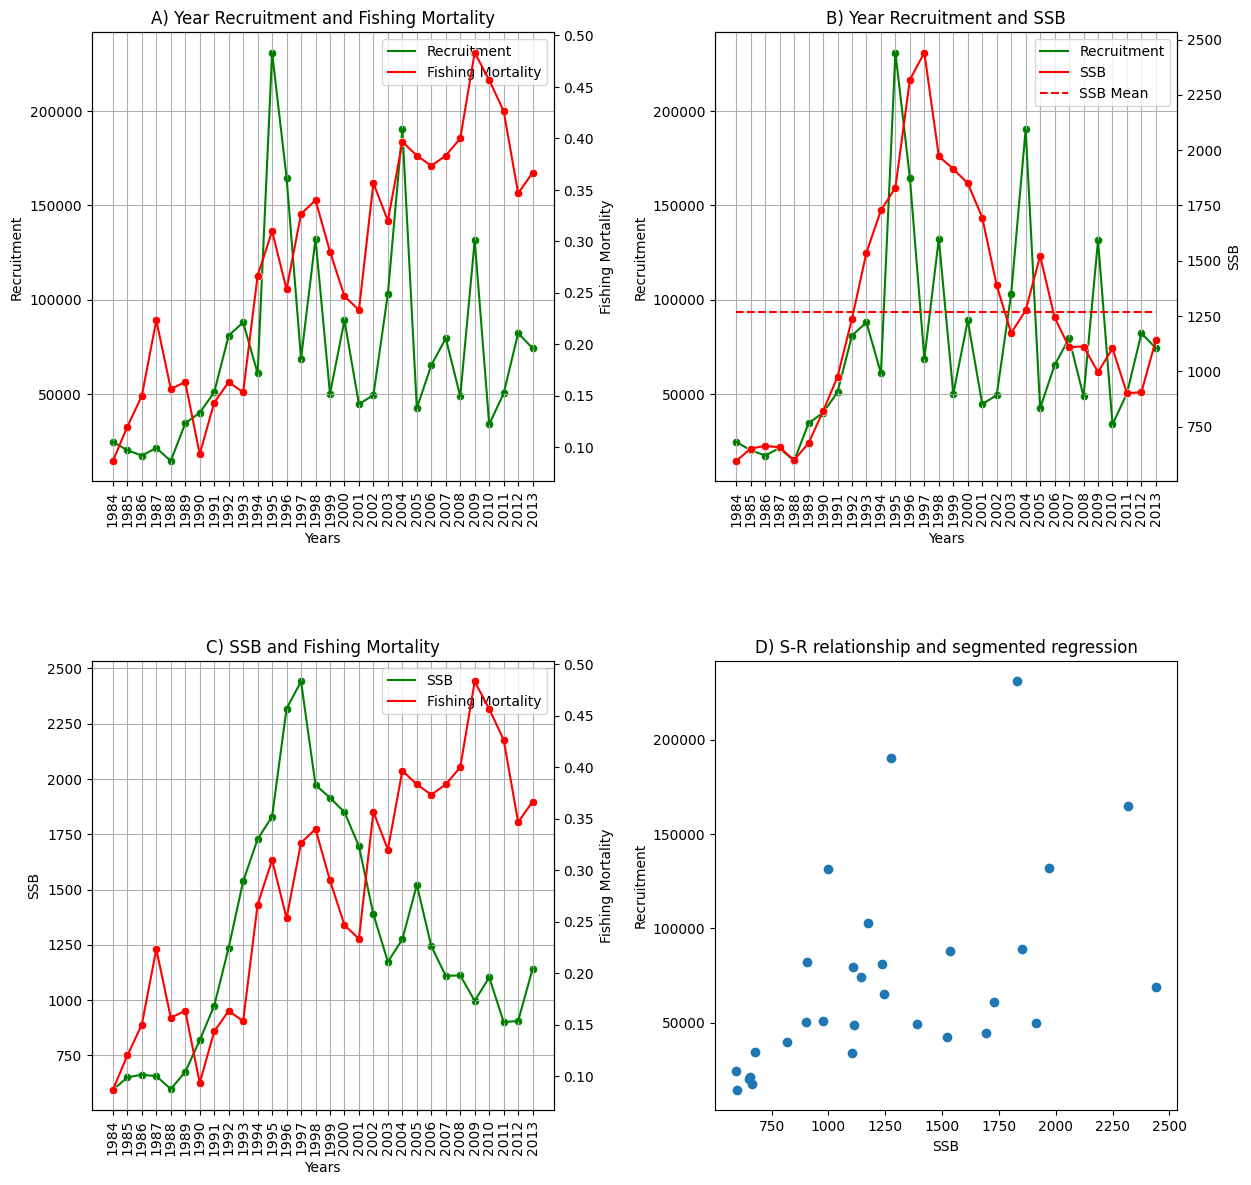

In [69]:
_, ax =plt.subplots(nrows=2, ncols=2, figsize=(14,14))

# # Plot segementation regrestion
pw_fit.plot()
ax[1][1].set_title("D) S-R relationship and segmented regression")
ax[1][1].set_xlabel("SSB")
ax[1][1].set_ylabel("Recruitment")

# Plot Year class recruitment and fishing mortality
ax_00 = ax[0][0].twinx()
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="rs", 
                color='g',
                ax = ax[0][0])
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='rs', 
             color='g',
             ax = ax[0][0])
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="fm",
                color='r',
                ax = ax_00)
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='fm', 
             color='r', 
             ax = ax_00)
ax_00.set_ylabel("Fishing Mortality")
ax[0][0].set(xticks=year_series)
ax[0][0].set_xticklabels(ax[0][0].get_xticks(), rotation = 90)
ax[0][0].set_title("A) Year Recruitment and Fishing Mortality")
ax[0][0].set_xlabel("Years")
ax[0][0].set_ylabel("Recruitment")
handles = build_twin_lineplot_legend ([{'color': 'g', 'label': 'Recruitment'}, 
                             {'color': 'r', 'label': 'Fishing Mortality'}])
ax[0][0].legend(handles = handles)
ax[0][0].grid()


# Plot Year class recruitment and SSB
ax_01 =ax[0][1].twinx()

sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="rs", 
                 color='g',
                ax = ax[0][1])
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='rs', 
             color='g',
             ax = ax[0][1])
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="ssb",
                color='r',
                ax = ax_01)
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='ssb', 
             color='r', 
             ax = ax_01)
sns.lineplot(x=year_series, 
             y=[fm_rs_ssb.ssb.mean()] * len(year_series), 
             color='r',
             linestyle='--',
             ax = ax_01)
ax_01.set_ylabel("SSB")
ax[0][1].set(xticks=year_series)
ax[0][1].set_xticklabels(ax[0][0].get_xticks(), rotation = 90)
ax[0][1].set_title("B) Year Recruitment and SSB")
ax[0][1].set_xlabel("Years")
ax[0][1].set_ylabel("Recruitment")
handles = build_twin_lineplot_legend ([{'color': 'g', 'label': 'Recruitment'}, 
                             {'color': 'r', 'label': 'SSB'}])
handles.append(mlines.Line2D([], [], color='r', label='SSB Mean', linestyle='--'))
ax[0][1].legend(handles = handles)
ax[0][1].grid()


# Plot SSB and mortality recruitment
ax_10 =ax[1][0].twinx()
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="ssb", 
                color='g',
                ax = ax[1][0])
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='ssb', 
             color='g',
             ax = ax[1][0])
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="fm",
                color='r',
                ax = ax_10)
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='fm', 
             color='r', 
             ax = ax_10)
ax_10.set_ylabel("Fishing Mortality")
ax[1][0].set(xticks=year_series)
ax[1][0].set_xticklabels(ax[1][0].get_xticks(), rotation = 90)
ax[1][0].set_title("C) SSB and Fishing Mortality")
ax[1][0].set_xlabel("Years")
ax[1][0].set_ylabel("SSB")
handles = build_twin_lineplot_legend ([{'color': 'g', 'label': 'SSB'}, 
                             {'color': 'r', 'label': 'Fishing Mortality'}])
ax[1][0].legend(handles = handles)
ax[1][0].grid()
plt.subplots_adjust(hspace=0.4, wspace=0.35)



In [70]:
pw_fit.summary()

Algorithm did not converge. Try different n_breakpoints, different start_values, or start_values=None
Summary of why the algorithm did not converge:
Run 1: Breakpoint values outside range 
Run 2: Algorithm stopped as max iterations reached 
Run 3: Breakpoint values outside range 
Run 4: Breakpoint values outside range 
Run 5: Breakpoint values outside range 
Run 6: Breakpoint values outside range 
Run 7: Algorithm stopped as max iterations reached 
Run 8: Breakpoint values outside range 
Run 9: Breakpoint values outside range 
Run 10: Breakpoint values outside range 
Run 11: Breakpoint values outside range 
Run 12: Breakpoint values outside range 
Run 13: Breakpoint values outside range 
Run 14: Breakpoint values outside range 
Run 15: Breakpoint values outside range 
Run 16: Breakpoint values outside range 
Run 17: Breakpoint values outside range 
Run 18: Algorithm stopped as max iterations reached 
Run 19: Algorithm stopped as max iterations reached 
Run 20: Algorithm stopped as max 

'Algorithm did not converge. Try different n_breakpoints, different start_values, or start_values=None\nSummary of why the algorithm did not converge:\nRun 1: Breakpoint values outside range \nRun 2: Algorithm stopped as max iterations reached \nRun 3: Breakpoint values outside range \nRun 4: Breakpoint values outside range \nRun 5: Breakpoint values outside range \nRun 6: Breakpoint values outside range \nRun 7: Algorithm stopped as max iterations reached \nRun 8: Breakpoint values outside range \nRun 9: Breakpoint values outside range \nRun 10: Breakpoint values outside range \nRun 11: Breakpoint values outside range \nRun 12: Breakpoint values outside range \nRun 13: Breakpoint values outside range \nRun 14: Breakpoint values outside range \nRun 15: Breakpoint values outside range \nRun 16: Breakpoint values outside range \nRun 17: Breakpoint values outside range \nRun 18: Algorithm stopped as max iterations reached \nRun 19: Algorithm stopped as max iterations reached \nRun 20: Alg

In [71]:
fm_rs_ssb.sort_values(by="ssb")

,year,ssb,rs,fm
0,1984,594.485985,24603.30,0.086667
4,1988,598.356686,14479.46,0.156667
1,1985,650.391597,20177.59,0.120000
3,1987,656.089270,21385.33,0.223333
2,1986,663.022127,17347.31,0.150000
5,1989,675.272937,34474.32,0.163333
6,1990,818.897660,40039.49,0.093333
27,2011,900.451817,50333.55,0.426667
28,2012,905.905716,82202.88,0.346667
7,1991,974.667916,50921.41,0.143333
